# Материалы:
* [Презентация] https://disk.yandex.ru/i/lzPGT5Fzkve7_w

# Игры — Анализ рекламных источников

## Описание проекта

Мобильная игра «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелегком деле колонизации галактики. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

### Описание данных

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом

- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv* содержит колонки:

- event_datetime — время события;

- event — одно из трёх событий:

    - building — объект построен,

    - finished_stage_1 — первый уровень завершён,

    - project — проект завершён;

- building_type — один из трёх типов здания:

    - assembly_shop — сборочный цех,

    - spaceport — космопорт,

    - research_center — исследовательский центр;

- user_id — идентификатор пользователя;

- project_type — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_cost.csv* содержит колонки:

- day - день, в который был совершен клик по объявлению
- source - источник трафика
- cost - стоимость кликов

Датасет *user_source.csv* содержит колонки:

- user_id - идентификатор пользователя
- source - источников, с которого пришёл пользователь, установивший приложение

### Цель исследования

Проанализируйте поведения игроков в зависимости от источника перехода.

- Проведите исследовательский анализ данных;
- Проанализируйте влияние источника перехода в игру на поведение пользователя;
- Проверьте статистические гипотезы
    - Проверьте гипотезу: время завершения уровня различается в зависимости способа прохождения:
        - через реализацию проекта,
        - через победу над первым игроком.
    - Сформулируйте собственную статистическую гипотезу. Дополните её нулевой и альтернативной гипотезами. Проверьте гипотезу с помощью статистического теста.

### Ход исследования

**Шаг 1.** Изучение общей информации

- Загрузка данных
- Первые выводы

**Шаг 2.** Предобработка данных

- Обработка пропусков
- Обработка типов данных
- Обработка дубликатов
- Поиск и исправление ошибок в данных


**Шаг 3.** Исследовательский анализ данных
- Анализ метрик, связанных с пользователями и событиями:
    - Количество пользователей
    - Количество событий
    - Соотношение событий и построек
- Анализ временных метрик:
    - Распределение событий во времени
    - Время прохождения уровня
- Анализ источников трафика
    - Количество пользователей пришедших с каждого источника трафика
    - Затраты на рекламу

**Шаг 4.** Статистические гипотезы

- Проверка гипотезы: время завершения уровня различается в зависимости способа прохождения:
    - через реализацию проекта,
    - через победу над первым врагом.
- Проверка гипотезы: способ прохождения игры не зависит от источника трафика

**Шаг 5.** Подведение итогов по проекту

**Шаг 6.** Оформление презентации по проекту

**Шаг 7.** Создание дашборда

**ШАГ 1. Изучение общей информации**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
from operator import is_not
from functools import partial
from scipy import stats as st

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150    
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# загружаем датасеты
game_actions =  pd.read_csv('/datasets/game_actions.csv', sep=',')
user_source =  pd.read_csv('/datasets/user_source.csv', sep=',')
ad_costs =  pd.read_csv('/datasets/ad_costs.csv', sep=',')

In [3]:
# функция выводящая общую информацию по каждому файлу
def basic_information(x):
    display(x.head(10)),
    x.info(),
    display(x.describe()),
    display(x.value_counts()),
    print('Количество дубликатов -',x.duplicated().sum()),
    x.columns = x.columns.str.lower()
    print('*'*50)

In [4]:
basic_information(game_actions)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
5,2020-05-04 00:00:36,building,assembly_shop,06c592ca-902d-42bb-bac3-75ce84cca159,NaN
6,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN
7,2020-05-04 00:00:38,building,assembly_shop,beb8ca15-33a9-465d-b47b-89aa96f89c9a,NaN
8,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN
9,2020-05-04 00:01:33,building,assembly_shop,fa352362-d258-472c-b295-2796ccc39fa3,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


Series([], dtype: int64)

Количество дубликатов - 1
**************************************************


In [5]:
basic_information(user_source)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct
6,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts
7,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
count,13576,13576
unique,13576,4
top,162bf61d-83ad-49f0-9dad-086c911dff6f,yandex_direct
freq,1,4817


user_id                               source                 
0001f83c-c6ac-4621-b7f0-8a28b283ac30  facebook_ads               1
a9ff93bd-0b96-4e89-bef7-c29326643faf  youtube_channel_reklama    1
aa08dc9a-f199-483d-aa43-2781abb889fc  instagram_new_adverts      1
aa0d0a62-0ba5-4d87-9467-4eb39d6b2d17  facebook_ads               1
aa122ae2-5e98-4d93-96dc-fdcf7016398e  facebook_ads               1
                                                                ..
53c5f5cc-975b-4be6-9a60-2a8fe0fc226f  instagram_new_adverts      1
53d146cf-1b2a-4038-8326-7900b021f418  yandex_direct              1
53d59f09-9745-4bdd-b6e5-56f98a5228d4  instagram_new_adverts      1
53d8dfd2-d601-461b-a4fd-890be5b45d27  yandex_direct              1
ffff69cc-fec1-4fd3-9f98-93be1112a6b8  facebook_ads               1
Length: 13576, dtype: int64

Количество дубликатов - 0
**************************************************


In [6]:
basic_information(ad_costs)

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77
5,facebook_ads,2020-05-08,68.01
6,facebook_ads,2020-05-09,38.72
7,instagram_new_adverts,2020-05-03,943.20
8,instagram_new_adverts,2020-05-04,502.93
9,instagram_new_adverts,2020-05-05,313.97


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,cost
count,28.00
mean,271.56
std,286.87
min,23.31
25%,66.75
50%,160.06
75%,349.03
max,969.14


source                   day         cost  
facebook_ads             2020-05-03  935.88    1
                         2020-05-04  548.35    1
youtube_channel_reklama  2020-05-08  40.22     1
                         2020-05-07  55.74     1
                         2020-05-06  88.51     1
                         2020-05-05  147.04    1
                         2020-05-04  259.07    1
                         2020-05-03  454.22    1
yandex_direct            2020-05-09  42.78     1
                         2020-05-08  62.96     1
                         2020-05-07  114.43    1
                         2020-05-06  180.92    1
                         2020-05-05  308.23    1
                         2020-05-04  554.65    1
                         2020-05-03  969.14    1
instagram_new_adverts    2020-05-09  46.78     1
                         2020-05-08  71.58     1
                         2020-05-07  109.92    1
                         2020-05-06  173.07    1
                         

Количество дубликатов - 0
**************************************************


**Выводы:**

- В датафрейме game_actions обнаружены пропуски в колонках : building_type и project_type (возможно это связано с тем, что эти пользователи прошли уровень путем ПВП)
- У дат неправильный тип данных
- В первом датафрейме имеется один дубликат
- С названиями столбцов всё в порядке

**Шаг 2. Предобработка данных**

**Замена типа данных**

In [7]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
game_actions['date'] = game_actions['event_datetime'].dt.strftime('%Y-%m-%d')
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

print(game_actions['event_datetime'].dtypes)
print(ad_costs['day'].dtypes)

datetime64[ns]
datetime64[ns]


**Обработка пропусков**

In [8]:
game_actions.isna().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
date                   0
dtype: int64

In [9]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64

In [10]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

Обработка пропусков в колонке **project_type**

In [11]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

В типах построек мы наблюдаем три вида: космодром, сборочный цех и исследовательский центр. В типах проекта видим "пропуски" и спутниковая орбитальная сборка.

По условиям задачи у нас существует 2 типа реализации проекта - победа над первым врагом либо разработка орбитальной сборки спутников. 
Значит пропущенные значения в столбце project_type - это как раз победа над врагом.

Заменим nan на "victory in pvp" (только для прошедших уровень)

In [12]:
game_actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [13]:
game_actions.loc[game_actions['project_type'].isna() & (game_actions['event'] == 'finished_stage_1'),
                                                                                  'project_type'] = 'victory_in_pvp'

In [14]:
game_actions['project_type'].isna().sum()

127957

127957 игроков не завершили уровень (заменим nan на "level_is not_passed")

In [15]:
game_actions.loc[game_actions['project_type'].isna(), 'project_type'] = 'level_is_not_passed'

In [16]:
game_actions['project_type'].isna().sum()

0

In [17]:
game_actions['project_type'].value_counts()

level_is_not_passed           127957
victory_in_pvp                  5817
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

Обработка пропусков в колонке **building_type**

In [18]:
# Посмотрим что стоит в графе событий напротив пропущенных значений
game_actions[game_actions['building_type'].isna()]['event'].unique() 

array(['finished_stage_1', 'project'], dtype=object)

In [19]:
game_actions.tail(10)

,event_datetime,event,building_type,user_id,project_type,date
135630,2020-06-04 08:29:42,project,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,satellite_orbital_assembly,2020-06-04
135631,2020-06-04 13:26:25,building,research_center,32572adb-900f-4b5d-a453-1eb1e6d88d8b,level_is_not_passed,2020-06-04
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,victory_in_pvp,2020-06-04
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,victory_in_pvp,2020-06-04
135634,2020-06-04 18:14:33,building,research_center,515c1952-99aa-4bca-a7ea-d0449eb5385a,level_is_not_passed,2020-06-04
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,level_is_not_passed,2020-06-05
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,victory_in_pvp,2020-06-05
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,level_is_not_passed,2020-06-05
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,victory_in_pvp,2020-06-05
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,victory_in_pvp,2020-06-05


Судя по имеющимся данным можно сделать вывод, что пропуски в колонке building_type - это те, кто перешли на следующий уровень(выполнив одно из 2 условий). Либо игрок победил в ПВП - т.е постройки не было, либо проект завершен полностью, в обоих случаях постройка уже не ведется, поэтому можно заменить nan на without_buildings

In [20]:
game_actions['building_type'] = game_actions['building_type'].fillna('without_buildings')

In [21]:
game_actions.isna().sum()

event_datetime    0
event             0
building_type     0
user_id           0
project_type      0
date              0
dtype: int64

**Обработка дубликатов**

In [22]:
game_actions.duplicated().sum()

1

In [23]:
# Найдем дубликат
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type,date
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,level_is_not_passed,2020-05-10


In [24]:
# Удалим дубликат
game_actions = game_actions.drop_duplicates()

In [25]:
# Проверяем удаление дубликата
game_actions.duplicated().sum()

0

**Шаг 3. Исследовательский анализ данных**

**Анализ метрик, связанных с пользователями и событиями:**

In [26]:
print("Количество пользователей =", game_actions['user_id'].nunique())
print("Количество событий =", game_actions['event'].count())

Количество пользователей = 13576
Количество событий = 135639


Т.е в среднем 10 событий на 1 пользователя

Теперь посчитаем количество событий по группам

In [27]:
events = game_actions.groupby('event').agg({'building_type':'count'}).reset_index().rename(columns={'building_type':'count'})
events['percent'] = round(events['count'] / events['count'].sum(),4) * 100
events

,event,count,percent
0,building,127956,94.34
1,finished_stage_1,5817,4.29
2,project,1866,1.38


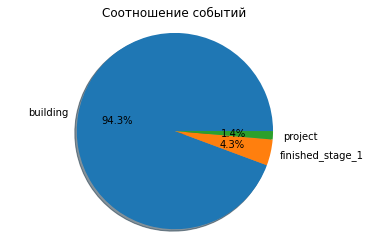

In [28]:
# построим диаграмму соотношения событий
fig, ax = plt.subplots()
ax.pie(events['count'],
       labels=events['event'],
       autopct='%1.1f%%',
       shadow=True)
ax.axis("equal")
plt.title("Соотношение событий")
plt.show()

Судя по диаграмме видим, что уровень прошли только 5.7% пользователей

**Группы завершивших и незавершивших уровень**

In [29]:
game_actions_df = game_actions.merge(user_source, how='inner')

In [30]:
ss = game_actions_df[game_actions_df['event'] == 'finished_stage_1']['user_id']
# соединяем таблицы по пользоватеям
mission_complete = game_actions_df.merge(ss, how='inner')#.reset_index(drop = True)
mission_complete # таблица прошедших уровень

,event_datetime,event,building_type,user_id,project_type,date,source
0,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-04,facebook_ads
1,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-06,facebook_ads
2,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads
3,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads
4,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads
...,...,...,...,...,...,...,...
68464,2020-05-17 04:55:13,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,level_is_not_passed,2020-05-17,youtube_channel_reklama
68465,2020-05-23 00:23:04,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,level_is_not_passed,2020-05-23,youtube_channel_reklama
68466,2020-05-26 14:36:17,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,level_is_not_passed,2020-05-26,youtube_channel_reklama
68467,2020-05-30 16:04:33,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,level_is_not_passed,2020-05-30,youtube_channel_reklama


In [31]:
failed_df = game_actions_df
failed_df = failed_df.set_index('user_id') # переносим пользователей в индекс для drop
failed_df = failed_df.drop(ss,axis = 0) # drop, с испоьзованием списка прошедших уровень
failed_df['user_id'] = failed_df.index
failed_df = failed_df.reset_index(drop=True) # перезначаем индекс
failed_df = failed_df[['event_datetime', 'event', 'building_type', 'user_id', 'source',
       'date']] # порядок столбцам
failed_df # таблица не прошедших

,event_datetime,event,building_type,user_id,source,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-04
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-05
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-05
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-05
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-06
...,...,...,...,...,...,...
67165,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,facebook_ads,2020-05-13
67166,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,facebook_ads,2020-05-18
67167,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,youtube_channel_reklama,2020-05-10
67168,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,youtube_channel_reklama,2020-05-13


In [32]:
#Добавляем к признак прохождения
mission_complete['passed'] = 1
failed_df['passed'] = 0

In [33]:
# объединяем таблицы
complete_df = mission_complete.merge(failed_df, how='outer')

In [34]:
complete_df.head()

,event_datetime,event,building_type,user_id,project_type,date,source,passed
0,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-04,facebook_ads,1
1,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-06,facebook_ads,1
2,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads,1
3,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads,1
4,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_is_not_passed,2020-05-07,facebook_ads,1


Посчитаем соотношение построек:

In [35]:
builds = (game_actions[game_actions['building_type'] != 'without_buildings']
          .groupby('building_type')
          .agg({'event':'count'})
          .reset_index()
          .rename(columns={'event':'count'}))

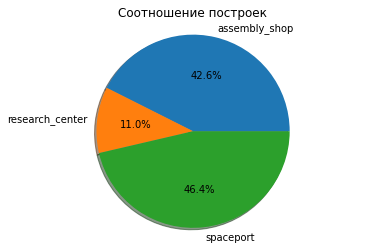

In [36]:
# построим диаграмму соотношения построек
fig, ax = plt.subplots()
ax.pie(builds['count'],
       labels=builds['building_type'],
       autopct='%1.1f%%',
       shadow=True)
ax.axis("equal")
plt.title("Соотношение построек")
plt.show()

Типы построек: assembly_shop — сборочный цех - 42.6%, spaceport — космопорт - 46.4%, research_center — исследовательский центр - 11%

**Рассмотрим динамику событий по их типу**

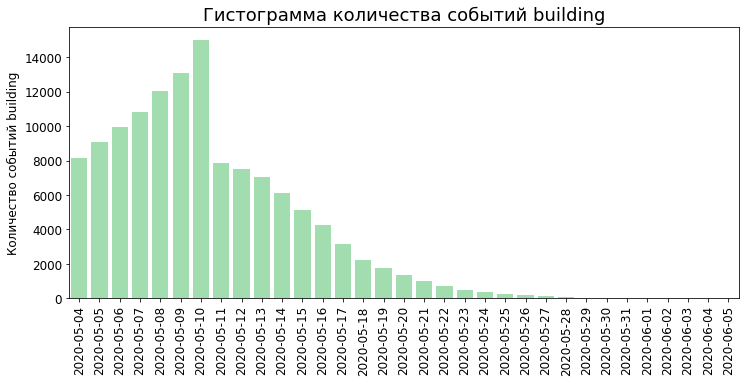

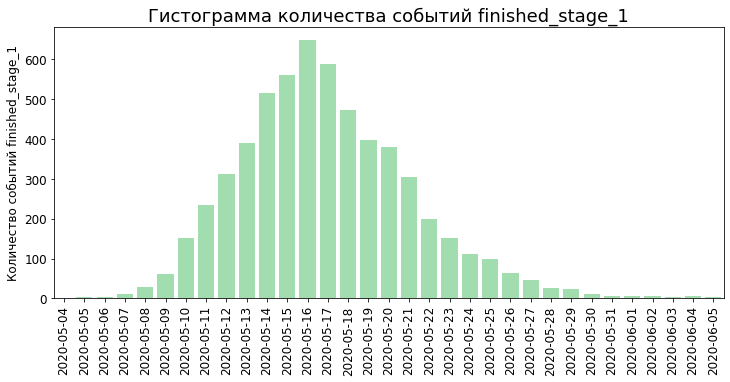

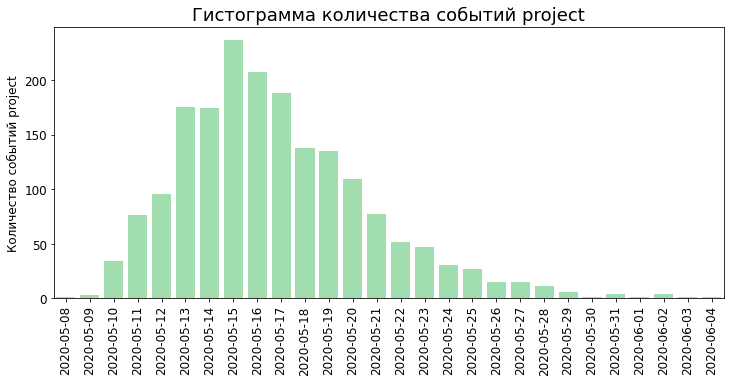

In [37]:
for i in game_actions['event'].unique():
    fig = plt.figure(figsize=(12, 5))
    sns.set_color_codes('pastel')
    splot_na = sns.barplot(x = game_actions[game_actions['event'] == i].pivot_table(index='date', values='user_id', aggfunc='count').index,
                       y = 'user_id',
                       data = game_actions[game_actions['event'] == i].pivot_table(index='date', values='user_id', aggfunc='count') ,
                       alpha = 0.9,
                       color = 'g')
    
    plt.title('Гистограмма количества событий {}'.format(i), fontsize=(18))
    plt.xlabel('', fontsize=(12))
    plt.ylabel('Количество событий {}'.format(i), fontsize=12)
    plt.xticks(fontsize=(12),rotation=90)
    plt.yticks(fontsize=(12))
    plt.xlabel('', size=(14))
    plt.show()

Динамика события building очевидно повторяет динамику общих событий (тоже с пиком 10го числа), так как тут происходит абсолютное большинство событий - 94 %. У события project пик событий приходится на 15е число. У события finished_stage_1 пик событий приходится на 16е число и занимают 4.3 % от всех событий.

Посмотрим типы построек события building , которые хранятся в building_type.

In [38]:
# фильтруем список
f = partial(is_not, np.nan)
x = game_actions['building_type'].unique()

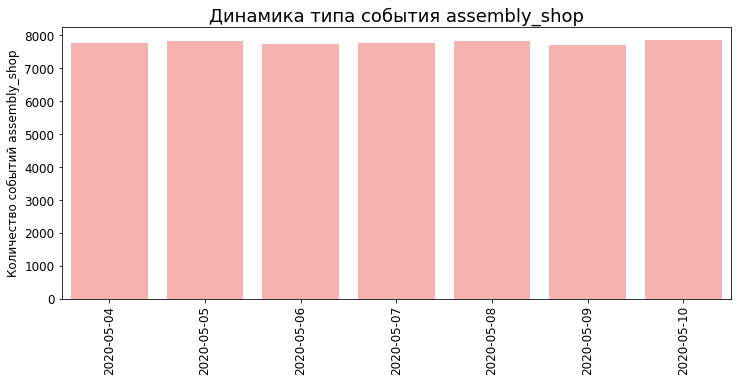

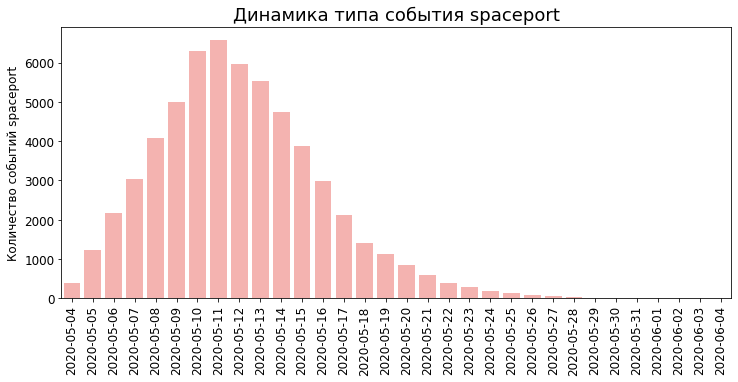

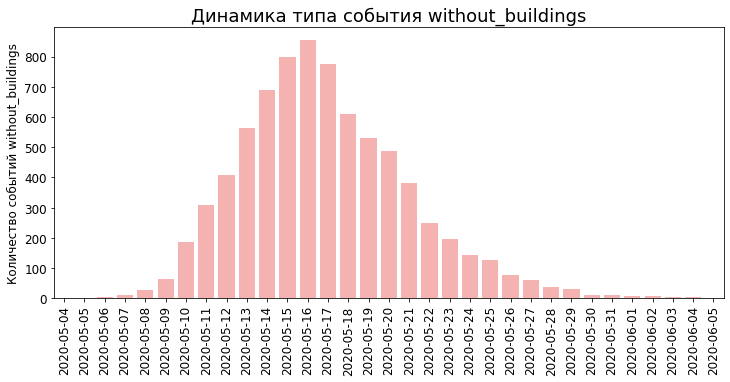

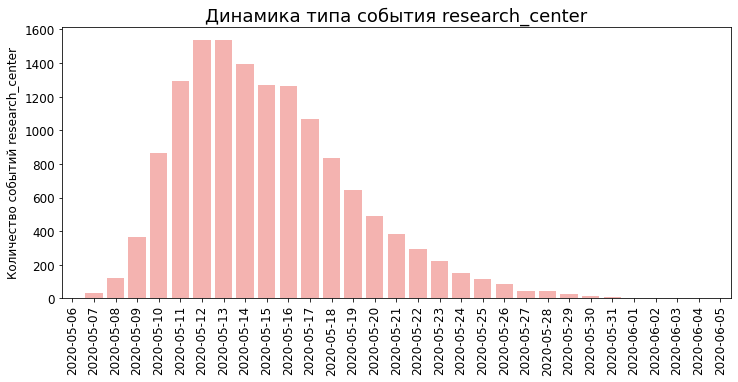

In [39]:
for i in list(filter(f, x)): # добавляем отфильтрованный список
    fig = plt.figure(figsize=(12, 5))
    sns.set_color_codes('pastel')
    splot_na = sns.barplot(x = game_actions[game_actions['building_type'] == i].pivot_table(index='date', values='user_id', aggfunc='count').index,
                       y = 'user_id',
                       data = game_actions[game_actions['building_type'] == i].pivot_table(index='date', values='user_id', aggfunc='count') ,
                       alpha = 0.9,
                       color = 'r')

    plt.title('Динамика типа события {}'.format(i), fontsize=(18))
    plt.xlabel('', fontsize=(12))
    plt.ylabel('Количество событий {}'.format(i), fontsize=12)
    plt.xticks(fontsize=(12),rotation=90)
    plt.yticks(fontsize=(12))
    plt.xlabel('', size=(14))
    plt.show()

Скорее всего assembly_shop(сборочный цех) это 1я необходимая постройка в игре, к т.к. каждый день количество было одинаковым. Тип события spaceport(космопорт) имеет нормальное распределение, пик которого 11го числа, скорее эта постройка открывается после assembly_shop. Событие research_center(исследовательский центр) начинается с 6го мая с пиком распределения 12го и 13го числа, не самая популярная постройка, так как на пике 1500 событий в день, предположительно оно идет после spaceport у которого число событий более 6000 на пике.

**Анализ временных метрик:**

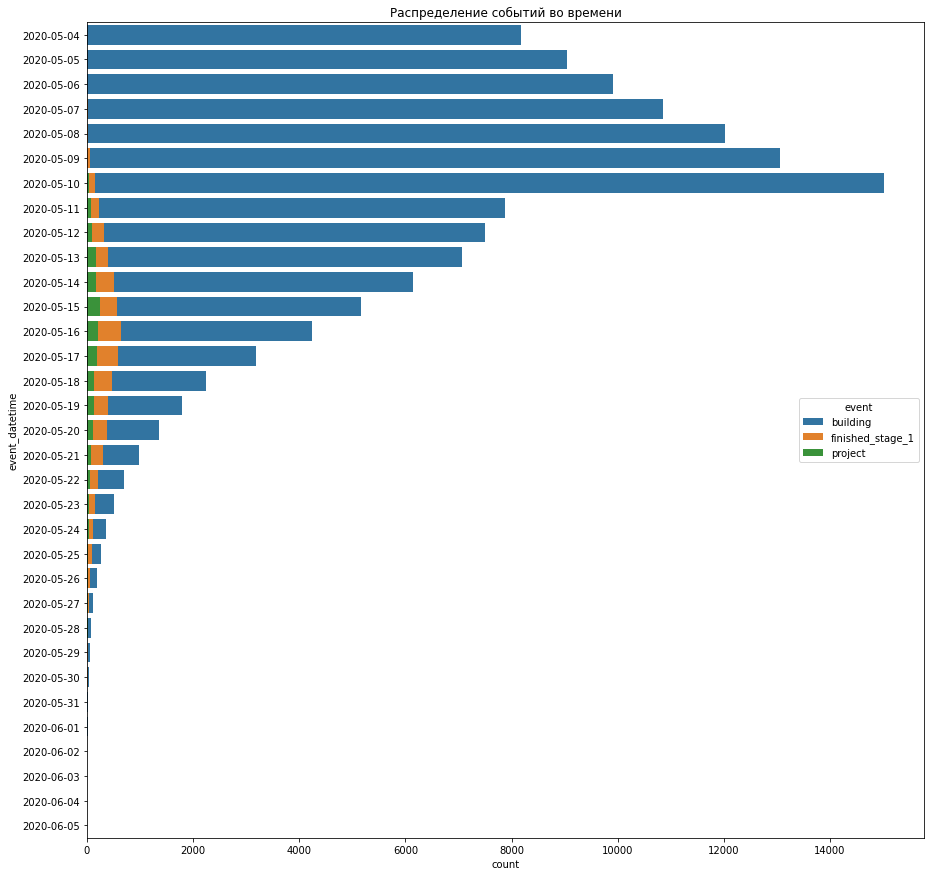

In [40]:
plt.figure(figsize=(15,15))
ax = sns.countplot(y=game_actions['event_datetime'].dt.strftime('%Y-%m-%d'), hue='event', data=game_actions, dodge=False)
ax.set_title('Распределение событий во времени')
plt.show()

По графику видно, что основной рост числа пользователей был с 4 по 10 мая, как и говорилось в условии. Начиная с 9 мая начали появляться те кто прошел уровень. Но также с 11 мая начал резко падать поток играющих пользователей.

Рассчитаем время прохождения уровня:

In [41]:
past_players = game_actions[game_actions['project_type'] != 'level_is_not_passed']['user_id']
passed_time = (game_actions
              .query('user_id in @past_players')
              .groupby('user_id')
              .agg({'event_datetime':['min','max']}))
passed_time['level_time'] = passed_time[('event_datetime', 'max')] - passed_time[('event_datetime', 'min')]
passed_time.columns = passed_time.columns.droplevel(1)
passed_time = passed_time.reset_index().sort_values(by='level_time')
passed_time

,user_id,event_datetime,event_datetime,level_time
91,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,2020-05-07 16:40:32,2020-05-08 02:19:33,0 days 09:39:01
4687,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04 00:13:21,2020-05-04 19:47:29,0 days 19:34:08
4547,c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7,2020-05-08 16:08:29,2020-05-09 11:52:33,0 days 19:44:04
825,2204ae7f-892b-494d-bd58-28816ff35eb5,2020-05-07 02:25:27,2020-05-08 01:02:51,0 days 22:37:24
1032,2ab1cc5a-413a-408e-ba76-01de8e12bead,2020-05-05 13:25:04,2020-05-06 13:43:12,1 days 00:18:08
...,...,...,...,...
1205,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-05-07 05:43:45,2020-06-05 12:12:27,29 days 06:28:42
3753,a4f54b34-299f-495f-b29f-745465741366,2020-05-04 05:00:48,2020-06-03 12:47:09,30 days 07:46:21
5497,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-05-06 02:56:25,2020-06-05 12:32:49,30 days 09:36:24
843,22cce310-fe10-41a2-941b-9c3d63327fea,2020-05-04 18:38:25,2020-06-04 15:50:38,30 days 21:12:13


Самое быстрое прохождение уровня - 9ч 39м, далее - 19ч 34м. Максимального значения по времени прохождения нет (т.к. большая часть пользователей не прошла уровень и может не собирается его проходить)

**Анализ источников трафика**

In [42]:
user_source

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


In [43]:
user_source['source'].value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

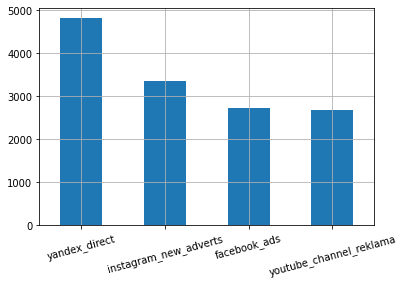

In [44]:
user_source['source'].value_counts().plot.bar(rot=15, grid=True)
plt.show()

Всего 4 источника трафика - Яндекс.Директ, Instagram, Facebook, Youtube. Больше всего пользователей пришло из Яндекс.Директ, меньше всего - из Youtube.

Посмотрим распределение суммарной стоимости кликов по источникам

In [45]:
users_and_sources = (user_source
              .groupby('source')
              .agg({'user_id':'nunique'})
              .rename(columns={'user_id':'users'})
              .reset_index())
users_and_sources

,source,users
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


In [46]:
traffic_sources = (ad_costs
       .groupby('source')
       .agg({'cost':'sum'})         
       .reset_index()
       .rename(columns={'cost':'sum'}))
traffic_sources

,source,sum
0,facebook_ads,"2,140.90"
1,instagram_new_adverts,"2,161.44"
2,yandex_direct,"2,233.11"
3,youtube_channel_reklama,"1,068.12"


Посчитаем соотношение стоимости кликов в зависимости от источника

In [47]:
counting_clicks = traffic_sources[['source','sum']].merge(users_and_sources, how='left', on='source')
counting_clicks['one_click'] = counting_clicks['sum']/counting_clicks['users']
counting_clicks

,source,sum,users,one_click
0,facebook_ads,"2,140.90",2726,0.79
1,instagram_new_adverts,"2,161.44",3347,0.65
2,yandex_direct,"2,233.11",4817,0.46
3,youtube_channel_reklama,"1,068.12",2686,0.40


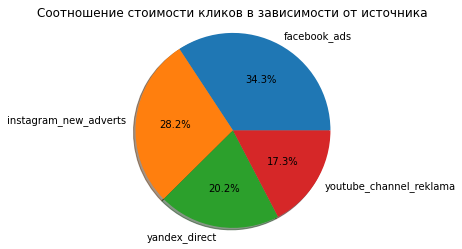

In [48]:
# Построим диаграмму соотношения стоимости кликов в зависимости от источника
fig, ax = plt.subplots()
ax.pie(counting_clicks['one_click'], labels=counting_clicks['source'], autopct='%1.1f%%', shadow=True)
ax.axis("equal")
plt.title("Соотношение стоимости кликов в зависимости от источника")
plt.show()

Судя по полученным данным можнл сделать вывод, что реклама на facebook самая дорогая - 0.79, она помогла привлечь 2726 пользователя. А на youtube самая дешевая - 0.40, и это привлекло почти столько же пользователей как и facebook - 2686. У Yandex.direct реклама чуть дороже - 0.46, хотя поток пользователей самый большой - 4817. Стоимость клика в instagram - 0.46, что дало 3347 пользователй.

**Прогноз окупаемости рекламы**

In [49]:
print('Общие затраты на источники:', round(ad_costs['cost'].sum(),2))

Общие затраты на источники: 7603.58


In [50]:
print('Количество построек:',game_actions_df[game_actions_df['event'] == 'building']['event'].count())

Количество построек: 127956


In [51]:
print('Что бы выйти в 0, нужно будет осуществлять показ рекламы стоимостью минимум',round(ad_costs['cost'].sum() / game_actions_df[game_actions_df['event'] == 'building']['event'].count(),2))


Что бы выйти в 0, нужно будет осуществлять показ рекламы стоимостью минимум 0.06


**Окупаемость рекламы с разбивкой по источникам**

In [52]:
payback = complete_df[complete_df['event']=='building'].pivot_table(index = 'source', values = 'event', aggfunc = 'count')
payback['$'] = payback['event'] * round(ad_costs['cost'].sum() / complete_df[complete_df['event'] == 'building']['event'].count(),2)
payback['cost'] = round(ad_costs.pivot_table(index = 'source', values = 'cost', aggfunc = 'sum')['cost'],2)
payback['payback'] = payback['$'] - payback['cost']

In [53]:
payback

,event,$,cost,payback
source,,,,
facebook_ads,26131,"1,567.86","2,140.90",-573.04
instagram_new_adverts,31815,"1,908.90","2,161.44",-252.54
yandex_direct,45032,"2,701.92","2,233.11",468.81
youtube_channel_reklama,24978,"1,498.68","1,068.12",430.56


Пользователи пришедшие из Яндекса, окупаются лучше всего - 468.81. С небольшим разрывом отстают пользователи с Ютюба - 430.56. Пользователи с Инстаграмм и Фэйсбук имеют убытки в размере 252.54 и 573.04.

**Выводы по Шагу 3**

- Количество пользователей - 13576
- Количество событий - 135639
- На одного пользователя в среднем 10 событий.
- В игре возможно построить 3 типа зданий, среди игроков они распределены так: assembly_shop — сборочный цех - 42.6%, spaceport — космопорт - 46.4%, research_center — исследовательский центр - 11%
- Самое быстрое время прохождения игры -  9ч 39м, максимального времени нет. Не все пользователи проходят игру.
- Всего 4 источника трафика - Яндекс.Директ, Instagram, Facebook, Youtube.
- Реклама на facebook самая дорогая - 0.79, (2726 пользователя). А на youtube самая дешевая - 0.40, (2686 пользователя), Yandex.direct - 0.46, поток пользователей самый большой - 4817.
- Пользователи пришедшие из Яндекса, окупаются лучше всего - 468.81. С небольшим разрывом отстают пользователи с Youtube - 430.56.
- Реклама на Youtube и Яндекс.Директ выглядит гораздо лучше, по сравнению с facebook. Поэтому рекомендуется сократить инвестиции на рекламу на facebook и перенаправить их на Яндекс.Директ и Youtube.

**Шаг 4. Статистические гипотезы**

- **Проверка гипотезы №1: время завершения уровня различается в зависимости способа прохождения:**
    - через реализацию проекта,
    - через победу над первым врагом.

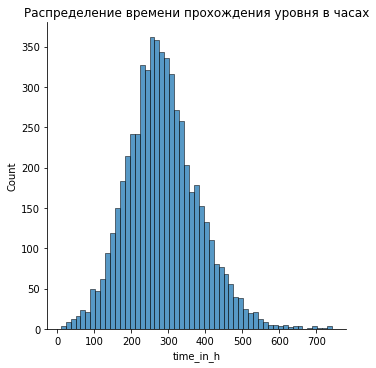

,user_id,event_datetime,event_datetime,level_time,time_in_h
91,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,2020-05-07 16:40:32,2020-05-08 02:19:33,0 days 09:39:01,9.65
4687,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04 00:13:21,2020-05-04 19:47:29,0 days 19:34:08,19.57
4547,c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7,2020-05-08 16:08:29,2020-05-09 11:52:33,0 days 19:44:04,19.73
825,2204ae7f-892b-494d-bd58-28816ff35eb5,2020-05-07 02:25:27,2020-05-08 01:02:51,0 days 22:37:24,22.62
1032,2ab1cc5a-413a-408e-ba76-01de8e12bead,2020-05-05 13:25:04,2020-05-06 13:43:12,1 days 00:18:08,24.30


In [54]:
# Использую ранее созданную таблицу passed_time
passed_time['time_in_h'] = passed_time['level_time'] / np.timedelta64(1, 'h') #переводим затраченное время в часы
sns.displot(passed_time['time_in_h'])
plt.title("Распределение времени прохождения уровня в часах")
plt.show()
passed_time.head()

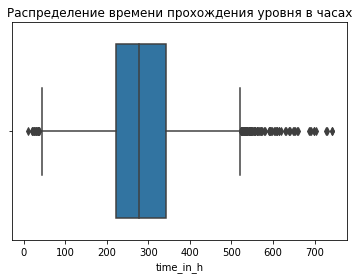

In [55]:
sns.boxplot(x=passed_time['time_in_h'])
plt.title("Распределение времени прохождения уровня в часах")
plt.show()

Наблюдаем выбросы, нужно избавиться от них

In [56]:
before = passed_time['time_in_h'].count()

In [57]:
passed_time = passed_time[passed_time['time_in_h'] < passed_time['time_in_h'].quantile(0.98)]
passed_time = passed_time[passed_time['time_in_h'] > passed_time['time_in_h'].quantile(0.004)]

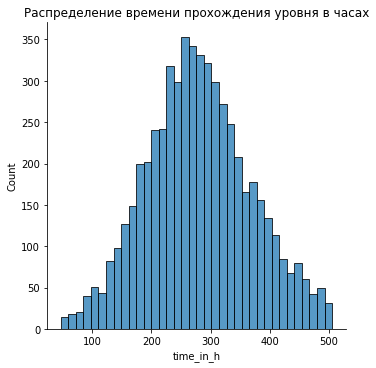

In [58]:
sns.displot(passed_time['time_in_h'])
plt.title("Распределение времени прохождения уровня в часах")
plt.show()

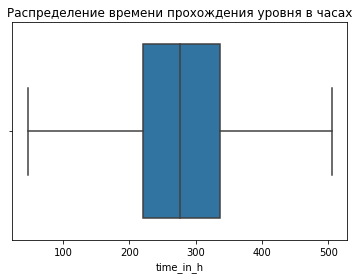

In [59]:
sns.boxplot(x=passed_time['time_in_h'])
plt.title("Распределение времени прохождения уровня в часах")
plt.show()

In [60]:
after = passed_time['time_in_h'].count()

In [61]:
print('Выбросы составили: {:.2%}'.format((after / before - 1)))

Выбросы составили: -2.41%


- **H0: Время завершения уровня не различается независимо от способа прохождения:**

    - через реализацию проекта
    - через победу над первым игроком

- **H1: Время завершения уровня различается в зависимости от способа прохождения:**

    - через реализацию проекта
    - через победу над первым игроком

In [62]:
# получим пользователей одержавших победу
user_finish = game_actions[(game_actions['project_type'] != 'level_is_not_passed')][['user_id', 'project_type']]

In [63]:
# получим пользователей одержавших победу через строительство
user_project = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly'][['user_id', 'project_type']]

In [64]:
# получим пользователей одержавших победу над игроком
user_fight = user_finish[~user_finish.isin(user_project['user_id'].unique())].dropna()

In [65]:
# добавим данные c бойцами и строителями к таблице
level_passing_time_project = passed_time[['user_id', 'time_in_h']].merge(user_project, how='left', on='user_id').dropna()
level_passing_time_user_fight = passed_time[['user_id', 'time_in_h']].merge(user_fight, how='left', on='user_id').dropna()

In [66]:
# разделим таблицу на 2 по типу проекта
victory_over_enemy = level_passing_time_user_fight['time_in_h']
satellite_orbital_assembly = level_passing_time_project['time_in_h']

In [67]:
satellite_orbital_assembly

187    123.37
205    127.37
251    134.27
253    134.40
291    139.48
        ...  
5670   503.27
5671   503.45
5672   504.30
5675   505.26
5676   505.42
Name: time_in_h, Length: 1810, dtype: float64

In [68]:
# задаем уровень статистической значимости
alpha = .05

results = st.ttest_ind(
    satellite_orbital_assembly, 
    victory_over_enemy)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('\nСреднее значения времени прохождения уровня \nПвП - {}\nСтроительство орбитальной станции - {}\nРазница - {}'
      .format(level_passing_time_user_fight['time_in_h'].mean().round(2),
              level_passing_time_project['time_in_h'].mean().round(2),
              (level_passing_time_project['time_in_h'].mean() -
              level_passing_time_user_fight['time_in_h'].mean()).round(2)))

p-значение: 1.7618154591760238e-101
Отвергаем нулевую гипотезу

Среднее значения времени прохождения уровня 
ПвП - 263.05
Строительство орбитальной станции - 315.69
Разница - 52.64


In [69]:
print('Среднее время прохождения уровня через бой -', level_passing_time_user_fight.mean())
print('Среднее время прохождения уровня через строительство -', level_passing_time_project.mean())

Среднее время прохождения уровня через бой - time_in_h   263.05
dtype: float64
Среднее время прохождения уровня через строительство - time_in_h   315.69
dtype: float64


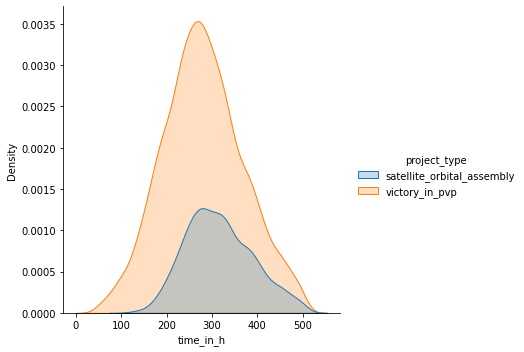

In [78]:
# Посмотрим распределение времени для завершения уровня по стратегиям
distribution_of_strategies = game_actions[['user_id','project_type']].merge(passed_time, how='left', on='user_id').dropna()
distribution_of_strategies  = distribution_of_strategies.drop(columns='event_datetime') 
distribution_of_strategies = distribution_of_strategies.query('project_type!="level_is_not_passed"')
sns.displot(x='time_in_h',
            hue='project_type',
            kind="kde",
            fill=True,
            data=distribution_of_strategies);

Получается, пока часть игроков ждала окончания постройки, остальная часть вовсю проходила уровень через пвп

**Вывод:**

 Отвергаем нулевую гипотезу, время завершения уровня зависит от способа прохождения

**Проверка гипотезы №2: способ прохождения игры не зависит от источника трафика**

- H0: Способ прохождения уровня не зависит от источника трафика
- H1: Способ прохождения уровня зависит от источника трафика
- Критический уровень значимости = 0.05

In [71]:
# для дальнейшей работы нам понадобится объединенная таблица
game_actions = pd.merge(game_actions, user_source, on='user_id') 
game_actions

,event_datetime,event,building_type,user_id,project_type,date,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_is_not_passed,2020-05-04,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_is_not_passed,2020-05-05,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_is_not_passed,2020-05-05,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_is_not_passed,2020-05-05,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_is_not_passed,2020-05-06,youtube_channel_reklama
...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,level_is_not_passed,2020-05-13,facebook_ads
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,level_is_not_passed,2020-05-18,facebook_ads
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,level_is_not_passed,2020-05-10,youtube_channel_reklama
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,level_is_not_passed,2020-05-13,youtube_channel_reklama


Для проверки гипотезы восползуемся критерием Уилкоксона-Манна-Уитни

In [72]:
passed_users2 = game_actions.loc[(game_actions['project_type'] != 'level_is_not_passed')] 
project2 = game_actions.loc[game_actions['project_type'] == 'satellite_orbital_assembly']
finished_stage = passed_users2[~passed_users2.isin(project2['user_id'].unique())].dropna()
finished_stage['test_id'] = 1
project2['test_id'] = 0

table= pd.concat([project2, finished_stage])

instagram_new_adverts = table[table['source'] == 'instagram_new_adverts']['test_id']
facebook_ads = table[table['source'] == 'facebook_ads']['test_id']
youtube_channel_reklama = table[table['source'] == 'youtube_channel_reklama']['test_id'] 
yandex_direct = table[table['source'] == 'yandex_direct']['test_id']

/tmp/ipykernel_297/107211441.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project2['test_id'] = 0


In [73]:
# Во избежание ложноположительных результатов, используем поправку Бонферрони
alpha_2 = .05 / 6 

In [74]:
def test_mw(H0, H1, title):
    print(title)

    results = st.mannwhitneyu(H0, H1)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha_2:
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
        )

In [75]:
test_mw(instagram_new_adverts, facebook_ads, 'instagram_new_adverts/facebook_ads')
test_mw(instagram_new_adverts, youtube_channel_reklama, 'instagram_new_adverts/youtube_channel_reklama')
test_mw(instagram_new_adverts, yandex_direct, 'instagram_new_adverts/yandex_direct')
test_mw(facebook_ads, youtube_channel_reklama, 'facebook_ads/youtube_channel_reklama')
test_mw(facebook_ads, yandex_direct, 'facebook_ads/yandex_direct')
test_mw(youtube_channel_reklama, yandex_direct, 'youtube_channel_reklama/yandex_direct')

instagram_new_adverts/facebook_ads
p-значение:  0.40919319567631285
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
instagram_new_adverts/youtube_channel_reklama
p-значение:  0.9001181567908461
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
instagram_new_adverts/yandex_direct
p-значение:  0.18426828022587327
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
facebook_ads/youtube_channel_reklama
p-значение:  0.5079689382321106
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
facebook_ads/yandex_direct
p-значение:  0.033959962425478496
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
youtube_channel_reklama/yandex_direct
p-значение:  0.17008753269777588
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Распределение нормальное, посмотрим распределение между способами прохождения уровня.

In [76]:
print('instagram_new_adverts')
print(instagram_new_adverts.value_counts())
print('facebook_ads')
print(facebook_ads.value_counts())
print('youtube_channel_reklama')
print(youtube_channel_reklama.value_counts())
print('yandex_direct')
print(yandex_direct.value_counts())

instagram_new_adverts
1    990
0    476
Name: test_id, dtype: int64
facebook_ads
1    759
0    391
Name: test_id, dtype: int64
youtube_channel_reklama
1    780
0    379
Name: test_id, dtype: int64
yandex_direct
1    1422
0     620
Name: test_id, dtype: int64


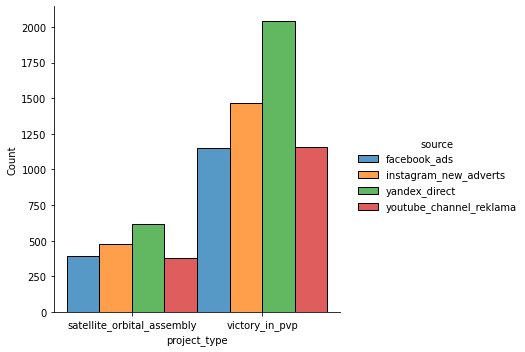

In [77]:
# построим график распределения
game_actions_win = game_actions.query('project_type!="level_is_not_passed"')
sns.displot(x='project_type',
            hue='source',
            multiple='dodge',
            data=game_actions_win);

По графику видно совмещение, по которому понятно, откуда приходит больше игроков и что путем ПвП прохождений первого уровня больше

**Вывод**

Способ прохождения игры не зависит от источника трафика

**Шаг 5. Подведение итогов по проекту**

В ходе проекта был проведен анализ данных о событиях, совершенных в мобильной игре «Космические братья». В результате предобработки был изменен тип данных у стобцов с датами, обработаны пропуски путем замены их на новые значения, обработаны дубликаты, после этого данные были готовы к анализу.

После этого был проведен исследовательский анализ данных, по результатам которого было выявлено:

- Количество пользователей - 13576
- Количество событий - 135639
- На одного пользователя в среднем приходится 10 событий.
- В игре возможно построить 3 типа зданий, среди игроков они распределены так: assembly_shop — сборочный цех - 42.6%, spaceport — космопорт - 46.4%, research_center — исследовательский центр - 11%
- Самое быстрое время прохождения игры -  9ч 39м, максимального времени нет. Не все пользователи проходят игру.
- Всего 4 источника трафика - Яндекс.Директ, Instagram, Facebook, Youtube.
- Реклама на facebook самая дорогая - 0.79, (2726 пользователя). А на youtube самая дешевая - 0.40, (2686 пользователя), Yandex.direct - 0.46, поток пользователей самый большой - 4817.

Далее были проверены 2 гипотезы, в результате проверки первой была отвергнута нулевая гипотеза, это означало, что способ прохождения игры влияет на время прохождения уровня.

Также была выдвинута собственная гипотеза, в результате проверки которой было выяснено, что способ прохождения игры не зависит от источника трафика.